In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np


def poly_lr_scheduler(optimizer, init_lr, iter, lr_decay_iter=1,
                      max_iter=300, power=0.9):
    """Polynomial decay of learning rate
            :param init_lr is base learning rate
            :param iter is a current iteration
            :param lr_decay_iter how frequently decay occurs, default is 1
            :param max_iter is number of maximum iterations
            :param power is a polymomial power

    """
    # if iter % lr_decay_iter or iter > max_iter:
    # 	return optimizer

    lr = init_lr*(1 - iter/max_iter)**power
    optimizer.param_groups[0]['lr'] = lr
    return lr
    # return lr


def fast_hist(a, b, n):
    '''
    a and b are label and prediction respectively
    n is the number of classes
    '''
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)


def per_class_iou(hist):
    epsilon = 1e-5
    return (np.diag(hist)) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)


In [ ]:
import torch
import torch.nn as nn

affine_par = True


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, affine=affine_par)
        for i in self.bn1.parameters():
            i.requires_grad = False
        padding = dilation
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=padding, bias=False, dilation=dilation)
        self.bn2 = nn.BatchNorm2d(planes, affine=affine_par)
        for i in self.bn2.parameters():
            i.requires_grad = False
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4, affine=affine_par)
        for i in self.bn3.parameters():
            i.requires_grad = False
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out


class ClassifierModule(nn.Module):
    def __init__(self, inplanes, dilation_series, padding_series, num_classes):
        super(ClassifierModule, self).__init__()
        self.conv2d_list = nn.ModuleList()
        for dilation, padding in zip(dilation_series, padding_series):
            self.conv2d_list.append(
                nn.Conv2d(inplanes, num_classes, kernel_size=3, stride=1, padding=padding,
                          dilation=dilation, bias=True))

        for m in self.conv2d_list:
            m.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.conv2d_list[0](x)
        for i in range(len(self.conv2d_list) - 1):
            out += self.conv2d_list[i + 1](x)
        return out


class ResNetMulti(nn.Module):
    def __init__(self, block, layers, num_classes):
        self.inplanes = 64
        super(ResNetMulti, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64, affine=affine_par)
        for i in self.bn1.parameters():
            i.requires_grad = False
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True)  # change
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1, dilation=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1, dilation=4)
        self.layer6 = ClassifierModule(2048, [6, 12, 18, 24], [6, 12, 18, 24], num_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.01)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1):
        downsample = None
        if (stride != 1
                or self.inplanes != planes * block.expansion
                or dilation == 2
                or dilation == 4):
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, affine=affine_par))
        for i in downsample._modules['1'].parameters():
            i.requires_grad = False
        layers = []
        layers.append(
            block(self.inplanes, planes, stride, dilation=dilation, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        _, _, H, W = x.size()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer6(x)

        x = torch.nn.functional.interpolate(x, size=(H, W), mode='bilinear')

        if self.training == True:
            return x, None, None

        return x

    def get_1x_lr_params_no_scale(self):
        """
        This generator returns all the parameters of the net except for
        the last classification layer. Note that for each batchnorm layer,
        requires_grad is set to False in deeplab_resnet.py, therefore this function does not return
        any batchnorm parameter
        """
        b = []

        b.append(self.conv1)
        b.append(self.bn1)
        b.append(self.layer1)
        b.append(self.layer2)
        b.append(self.layer3)
        b.append(self.layer4)

        for i in range(len(b)):
            for j in b[i].modules():
                jj = 0
                for k in j.parameters():
                    jj += 1
                    if k.requires_grad:
                        yield k

    def get_10x_lr_params(self):
        """
        This generator returns all the parameters for the last layer of the net,
        which does the classification of pixel into classes
        """
        b = []
        if self.multi_level:
            b.append(self.layer5.parameters())
        b.append(self.layer6.parameters())

        for j in range(len(b)):
            for i in b[j]:
                yield i

    def optim_parameters(self, lr):
        return [{'params': self.get_1x_lr_params_no_scale(), 'lr': lr},
                {'params': self.get_10x_lr_params(), 'lr': 10 * lr}]


def get_deeplab_v2(num_classes=19, pretrain=True, pretrain_model_path='DeepLab_resnet_pretrained_imagenet.pth'):
    model = ResNetMulti(Bottleneck, [3, 4, 23, 3], num_classes)

    # Pretraining loading
    if pretrain:
        print('Deeplab pretraining loading...')
        saved_state_dict = torch.load(pretrain_model_path)

        new_params = model.state_dict().copy()
        for i in saved_state_dict:
            i_parts = i.split('.')
            new_params['.'.join(i_parts[1:])] = saved_state_dict[i]
        model.load_state_dict(new_params, strict=False)

    return model

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CityScapes(Dataset):
    def __init__(self, root_dir, split='train', transform=None, target_transform=None):
        super(CityScapes, self).__init__()
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.target_transform = target_transform

        self.images_dir = os.path.join(root_dir, 'images', split)
        self.labels_dir = os.path.join(root_dir, 'gtFine', split)

        self.images = []
        self.labels = []

        for city in os.listdir(self.images_dir):
            img_dir = os.path.join(self.images_dir, city)
            lbl_dir = os.path.join(self.labels_dir, city)

            for file_name in os.listdir(img_dir):
                if file_name.endswith('_leftImg8bit.png'):
                    img_path = os.path.join(img_dir, file_name)
                    lbl_path = os.path.join(lbl_dir, file_name.replace('_leftImg8bit.png', '_gtFine_labelTrainIds.png'))

                    if not os.path.exists(img_path):
                        print(f"Image file does not exist: {img_path}")
                    if not os.path.exists(lbl_path):
                        print(f"Label file does not exist: {lbl_path}")

                    self.images.append(img_path)
                    self.labels.append(lbl_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        lbl_path = self.labels[idx]

        image = Image.open(img_path).convert('RGB')
        label = Image.open(lbl_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

    def get_class_names(self):
        return ['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign',
                'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train',
                'motorcycle', 'bicycle']


In [ ]:
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Hyperparameters
num_epochs = 50
learning_rate = 1e-4
batch_size = 4
num_classes = 19
root_dir = '/content/drive/MyDrive/Colab Notebooks/MlDl/Cityscapes/Cityscapes/Cityspaces'

# Transforms
transform = transforms.Compose([
    transforms.Resize((512, 1024)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

target_transform = transforms.Compose([
    transforms.Resize((512, 1024), interpolation=Image.NEAREST),
    transforms.Lambda(lambda lbl: torch.tensor(np.array(lbl), dtype=torch.long)),
])

# Dataset and Dataloader
train_dataset = CityScapes(root_dir=root_dir, split='train', transform=transform, target_transform=target_transform)
val_dataset = CityScapes(root_dir=root_dir, split='val', transform=transform, target_transform=target_transform)

print(f"Dataset size: {len(train_dataset)}")
print(f"Val_Dataset size: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12)

# Model
model = get_deeplab_v2(num_classes=num_classes, pretrain=True, pretrain_model_path='/content/drive/MyDrive/Colab Notebooks/MlDl/deeplab_resnet_pretrained_imagenet.pth').to(device)

# Loss
criterion = nn.CrossEntropyLoss(ignore_index=255)
# Optimizer - change from Adam to SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

class_names = train_dataset.get_class_names()

cuda
Dataset size: 1572
Val_Dataset size: 500
Deeplab pretraining loading...


In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

best_mIoU = 0.0
train_losses = []
val_losses = []
train_mIoUs = []
val_mIoUs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    hist_train = np.zeros((num_classes, num_classes))
    for iter, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device).long()

        # Forward pass
        optimizer.zero_grad()
        outputs, _, _ = model(images)  # Extract the first element of the tuple
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update learning rate
        current_iter = epoch * len(train_loader) + iter
        poly_lr_scheduler(optimizer, learning_rate, current_iter, max_iter=num_epochs * len(train_loader))

        running_loss += loss.item()

        # Calculate training mIoU
        preds_train = torch.argmax(outputs, dim=1)
        hist_train += fast_hist(labels.cpu().numpy().flatten(), preds_train.cpu().numpy().flatten(), num_classes)

        if (iter + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{iter+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    train_mIoUs_epoch = per_class_iou(hist_train)
    avg_train_mIoU = np.mean(train_mIoUs_epoch)
    train_mIoUs.append(avg_train_mIoU)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Mean mIoU: {avg_train_mIoU:.4f}')

    # Validation
    model.eval()
    hist_val = np.zeros((num_classes, num_classes))
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            preds_val = torch.argmax(outputs, dim=1)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

            hist_val += fast_hist(labels.cpu().numpy().flatten(), preds_val.cpu().numpy().flatten(), num_classes)

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_mIoUs_epoch = per_class_iou(hist_val)
    avg_val_mIoU = np.mean(val_mIoUs_epoch)
    val_mIoUs.append(avg_val_mIoU)
    print(f'Epoch [{epoch+1}/{num_epochs}], Val Mean mIoU: {avg_val_mIoU:.4f}')
    for i, iou in enumerate(val_mIoUs_epoch):
        print(f'{class_names[i]}: Val mIoU = {iou:.4f}')

    # Save the model if it has the best mIoU so far
    if avg_val_mIoU > best_mIoU:
        best_mIoU = avg_val_mIoU
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/MlDl/best_model_2a.pth')
        print(f'Model saved with Mean mIoU: {avg_val_mIoU:.4f}')

    # Clear cache to free up memory
    torch.cuda.empty_cache()

Epoch [1/50], Step [10/393], Loss: 0.5811
Epoch [1/50], Step [20/393], Loss: 0.9163
Epoch [1/50], Step [30/393], Loss: 0.5342
Epoch [1/50], Step [40/393], Loss: 0.6694
Epoch [1/50], Step [50/393], Loss: 0.6781
Epoch [1/50], Step [60/393], Loss: 0.6819
Epoch [1/50], Step [70/393], Loss: 0.6341
Epoch [1/50], Step [80/393], Loss: 0.9583
Epoch [1/50], Step [90/393], Loss: 0.6145
Epoch [1/50], Step [100/393], Loss: 0.6109
Epoch [1/50], Step [110/393], Loss: 0.5854
Epoch [1/50], Step [120/393], Loss: 0.6445
Epoch [1/50], Step [130/393], Loss: 0.8142
Epoch [1/50], Step [140/393], Loss: 0.4598
Epoch [1/50], Step [150/393], Loss: 0.7114
Epoch [1/50], Step [160/393], Loss: 0.8706
Epoch [1/50], Step [170/393], Loss: 0.6697
Epoch [1/50], Step [180/393], Loss: 0.6793
Epoch [1/50], Step [190/393], Loss: 0.6743
Epoch [1/50], Step [200/393], Loss: 0.5946
Epoch [1/50], Step [210/393], Loss: 0.7305
Epoch [1/50], Step [220/393], Loss: 0.8523
Epoch [1/50], Step [230/393], Loss: 0.4399
Epoch [1/50], Step [

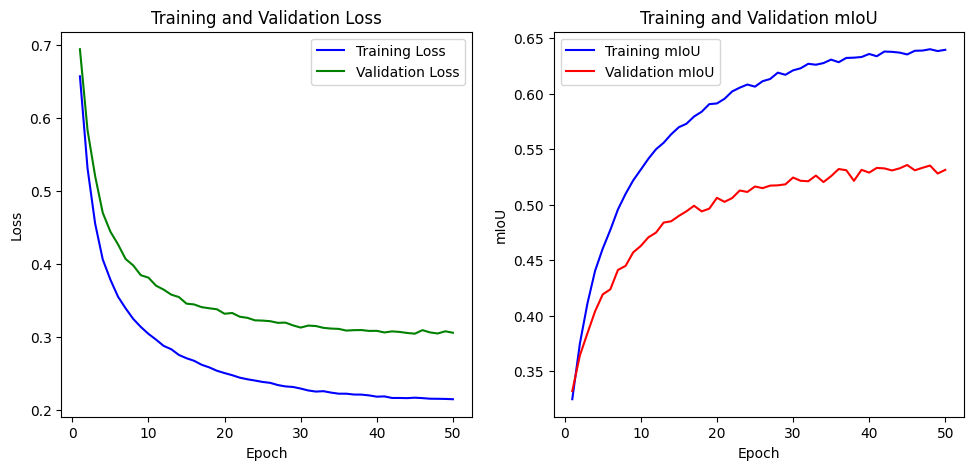

In [ ]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'g-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_mIoUs, 'b-', label='Training mIoU')
plt.plot(epochs, val_mIoUs, 'r-', label='Validation mIoU')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('Training and Validation mIoU')
plt.legend()

plt.show()